# 方法一：Decision Tree

## Scikit-Learn 版（AdaBoost + Decision Tree Classifier）

Accuracy: 0.493177387914


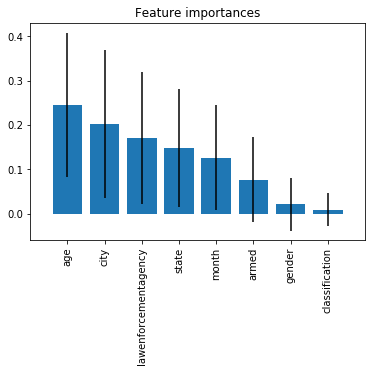

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

# 1.read data
df_2015 = pd.DataFrame(pd.read_csv('the-counted-2015.csv'))
df_2016 = pd.DataFrame(pd.read_csv('the-counted-2016.csv'))
df = pd.concat([df_2015, df_2016], ignore_index = True)

# 2.處理資料
df = df.drop(['uid', 'name', 'day', 'year', 'streetaddress'], 1)
df = df.drop(df.index[np.where((df['raceethnicity'] == 'Unknown') | (df['age'] == 'Unknown') | (df['armed'] == 'Unknown') | (df['lawenforcementagency'] == 'Unknown'))])

# replace data to int
df = df.replace(['Male', 'Female', 'Non-conforming', '40s'], [0, 1, 0, 40])
df['month'] = df['month'].replace(list(Counter(df['month'])), np.arange(len(Counter(df['month']))) + 1)
df['city'] = df['city'].replace(list(Counter(df['city'])), np.arange(len(Counter(df['city']))))
df['state'] = df['state'].replace(list(Counter(df['state'])), np.arange(len(Counter(df['state']))))
df['classification'] = df['classification'].replace(list(Counter(df['classification'])), np.arange(len(Counter(df['classification']))))
df['lawenforcementagency'] = df['lawenforcementagency'].replace(list(Counter(df['lawenforcementagency'])), np.arange(len(Counter(df['lawenforcementagency']))))
df['armed'] = df['armed'].replace(list(Counter(df['armed'])), np.arange(len(Counter(df['armed']))))

# target value
cls = df['raceethnicity']
df = df.drop(['raceethnicity'], 1)
df.insert(loc = 0, column = 'raceethnicity', value = cls)

# save as csv
df.to_csv('out_police.csv')

# 3.split train, test data
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, 0], test_size = int(len(df)*0.25))

# 4.train a model
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 5), n_estimators = 100)
clf.fit(x_train, y_train)
importances = clf.feature_importances_
predict = clf.predict(x_test)

# 5.calaulate accuracy, precision, recall
accuracy = metrics.accuracy_score(y_test, predict)
print('Accuracy:', accuracy)

# 6.plot 20 important features
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]
feature = []
for i in range(len(indices)):
    feature.append(list(df)[indices[i]+1])
plt.bar(range(len(indices)), importances[indices], yerr = std[indices], align = 'center')
plt.title('Feature importances')
plt.xticks(range(len(indices)), feature, rotation = 'vertical')
plt.xlim([-1, len(indices)])
plt.show()

### 調整參數

Accuracy: 54.5808966862 %


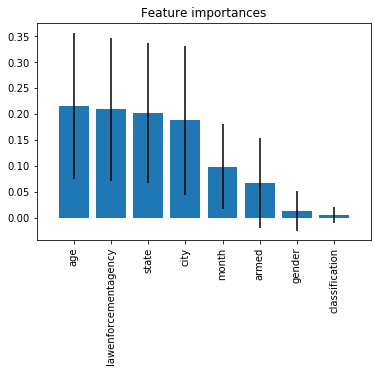

In [2]:
# Tuning
# 4. train a model
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8), n_estimators=100, learning_rate=0.6)
clf.fit(x_train, y_train)
importances = clf.feature_importances_
predict = clf.predict(x_test)

# 5. calaulate accuracy, precision, recall
accuracy = metrics.accuracy_score(y_test, predict)
print('Accuracy:', accuracy * 100, '%')

# 6. plot 20 important features
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
feature = []
for i in range(len(indices)):
    feature.append(list(df)[indices[i] + 1])
plt.bar(range(len(indices)), importances[indices], yerr=std[indices], align='center')
plt.title('Feature importances')
plt.xticks(range(len(indices)), feature, rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

## PySpark版

###  資料前處理

In [1]:
from pyspark.sql import DataFrame

In [2]:
# Read CSV
spark_df = spark.read.csv('out_police.csv', header=True)

NameError: name 'spark' is not defined

In [3]:
# Drop Unused Column
spark_df = spark_df.drop(spark_df.columns[0])

In [4]:
from pyspark.sql.types import *

In [5]:
# Convert columns types
def convertColumn(df, colNames, newType):
    for name in colNames:
        df = df.withColumn(name, df[name].astype(newType))
    return df


spark_df = convertColumn(spark_df, spark_df.columns[1:], IntegerType())
spark_df.dtypes

[('raceethnicity', 'string'),
 ('age', 'int'),
 ('gender', 'int'),
 ('month', 'int'),
 ('city', 'int'),
 ('state', 'int'),
 ('classification', 'int'),
 ('lawenforcementagency', 'int'),
 ('armed', 'int')]

In [6]:
from pyspark.ml.feature import VectorAssembler

In [7]:
# Vectorize Features
vecAssembler = VectorAssembler(inputCols=['age','gender','month','city','state','classification','lawenforcementagency','armed'], outputCol="features")
spark_df = vecAssembler.transform(spark_df)

In [8]:
from pyspark.ml.feature import StringIndexer

In [9]:
# Encode Labels
stringIndexer = StringIndexer(inputCol='raceethnicity', outputCol='label', handleInvalid='error')
model = stringIndexer.fit(spark_df)
td = model.transform(spark_df)

In [10]:
# Split Data
train, test = td.randomSplit(weights=[0.75, 0.25])

### 訓練Model

In [11]:
from pyspark.ml.classification import DecisionTreeClassifier

In [12]:
# Training
dt = DecisionTreeClassifier(maxDepth=6, featuresCol='features', labelCol='label')
model = dt.fit(train)

In [13]:
print(model.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_41c6befb27ced9e17183) of depth 6 with 95 nodes
  If (feature 0 <= 43.0)
   If (feature 4 <= 18.0)
    If (feature 4 <= 4.0)
     If (feature 4 <= 0.0)
      If (feature 0 <= 25.0)
       If (feature 5 <= 1.0)
        Predict: 1.0
       Else (feature 5 > 1.0)
        Predict: 0.0
      Else (feature 0 > 25.0)
       If (feature 6 <= 491.0)
        Predict: 1.0
       Else (feature 6 > 491.0)
        Predict: 0.0
     Else (feature 4 > 0.0)
      If (feature 3 <= 211.0)
       If (feature 4 <= 3.0)
        Predict: 0.0
       Else (feature 4 > 3.0)
        Predict: 0.0
      Else (feature 3 > 211.0)
       If (feature 6 <= 162.0)
        Predict: 3.0
       Else (feature 6 > 162.0)
        Predict: 0.0
    Else (feature 4 > 4.0)
     If (feature 4 <= 5.0)
      If (feature 6 <= 48.0)
       If (feature 2 <= 4.0)
        Predict: 2.0
       Else (feature 2 > 4.0)
        Predict: 2.0
      Else (feature 6 > 48.0)
       If (feat

In [14]:
# Features Importances
model.featureImportances.toArray()

array([ 0.30868283,  0.00959885,  0.04865358,  0.14490841,  0.31974658,
        0.03957876,  0.09262769,  0.03620331])

In [15]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [16]:
# Tuning
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')

In [17]:
grid = ParamGridBuilder().addGrid(dt.maxDepth, [5, 21]).build()
tvs = TrainValidationSplit(estimator=dt, estimatorParamMaps=grid, evaluator=evaluator, trainRatio=0.3)
tvsModel = tvs.fit(train)
evaluator.evaluate(tvsModel.transform(train))

0.601416613007083

### 測試Model

In [20]:
# Testing
prediction = model.transform(test)
metric = evaluator.evaluate(prediction)
print('Decision Tree Accuracy:', metric * 100, '%')

Decision Tree Accuracy: 56.37450199203188 %


In [1]:
print('Tuned Decision Tree Accuracy:', evaluator.evaluate(tvsModel.transform(test)) * 100, '%')

NameError: name 'evaluator' is not defined